In [18]:
import re
from pathlib import Path

import numpy as np

import jax.lax
from jax.random import PRNGKey
import jax.numpy as jnp
import optax
from flax.training.train_state import TrainState
from itertools import zip_longest   # or just `zip` if the two loaders are equal length



import matplotlib.pyplot as plt

data_dir = "./data"
print(f"Data resides in        : {data_dir}")

Data resides in        : ./data


In [19]:
class MultiBasisDataLoader:
    def __init__(self, data_dict: dict[str, jnp.ndarray],
                 batch_size: int = 128,
                 shuffle: bool = True,
                 drop_last: bool = False,
                 seed: int = 0):
        lengths = [len(v) for v in data_dict.values()]
        if len(set(lengths)) != 1:
            raise ValueError(f"All arrays must have the same length, got: {lengths}")

        self.data = data_dict
        self.n = lengths[0]
        self.bs = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.rng = np.random.default_rng(seed)

        self.idx_slices = [
            (i, i + batch_size)
            for i in range(0, self.n, batch_size)
            if not drop_last or i + batch_size <= self.n
        ]

    def __iter__(self):
        self.order = np.arange(self.n)
        if self.shuffle:
            self.rng.shuffle(self.order)
        self.slice_idx = 0
        return self

    def __next__(self):
        if self.slice_idx >= len(self.idx_slices):
            raise StopIteration
        s, e = self.idx_slices[self.slice_idx]
        self.slice_idx += 1
        return {k: v[self.order[s:e]] for k, v in self.data.items()}


def load_measurements(folder: str, file_pattern: str = "w_*.txt") -> dict[str, jnp.ndarray]:
    out: dict[str, jnp.ndarray] = {}

    for fp in Path(folder).glob(file_pattern):
        basis = fp.stem.split("_")[2]

        bitstrings = []
        with fp.open() as f:
            for line in f:
                bitstring = np.fromiter((c.islower() for c in line.strip()), dtype=np.float32)
                bitstrings.append(bitstring)

        arr = jnp.asarray(np.stack(bitstrings))
        if basis in out:
            out[basis] = jnp.concatenate([out[basis], arr], axis=0)
        else:
            out[basis] = arr

    return out

In [20]:
data_dict = load_measurements("data/", "w_*.txt")

# 2. Create two basis key groups (regex matched)
amp_keys = [k for k in data_dict if re.fullmatch(r"^Z+$", k)]
pha_keys = [k for k in data_dict if re.fullmatch(r"^(?!Z+$).*", k)]

amp_dict = {k: data_dict[k] for k in amp_keys}
pha_dict = {k: data_dict[k] for k in pha_keys}

loader_amp           = MultiBasisDataLoader(amp_dict, batch_size=128)
loader_pha           = MultiBasisDataLoader(pha_dict, batch_size=128)

In [21]:
from typing import Tuple, Dict, Any
from typing import Optional
import jax
import jax.numpy as jnp
from jax import random
from flax import linen as nn
from flax.core import freeze, unfreeze
from jax.nn.initializers import normal, zeros
from collections.abc import Callable, Sequence


class DoubleRBM(nn.Module):
    n_visible: int
    n_hidden: int
    k: int = 1
    n_chains: int = 1000

    def setup(self):
        self.W_amp = self.param("W_amp", nn.initializers.normal(0.01), (self.n_visible, self.n_hidden))
        self.b_amp = self.param("b_amp", nn.initializers.zeros, (self.n_visible,))
        self.c_amp = self.param("c_amp", nn.initializers.zeros, (self.n_hidden,))

        self.W_pha = self.param("W_pha", nn.initializers.normal(0.01), (self.n_visible, self.n_hidden))
        self.b_pha = self.param("b_pha", nn.initializers.zeros, (self.n_visible,))
        self.c_pha = self.param("c_pha", nn.initializers.zeros, (self.n_hidden,))

        self.rotators = {
            'X': jnp.array([[1, 1], [1, -1]], dtype=jnp.complex64) / jnp.sqrt(2),
            'Y': jnp.array([[1, -1j], [1, 1j]], dtype=jnp.complex64) / jnp.sqrt(2),
        }

    def __call__(
            self,
            data_dict: Dict[str, jnp.ndarray],
            aux_vars: Dict[str, Any]) -> Tuple[jnp.ndarray, Dict[str, Any]]:

        random_key = aux_vars.get("random_key")

        aux_vars = dict()

        # amplitude training
        comp_basis = 'Z' * self.n_visible
        if len(data_dict) == 1 and comp_basis in data_dict:
            data_batch = data_dict[comp_basis]
            pcd_loss, random_key = self._loss_amp(data_batch, random_key)
            aux_vars["random_key"] = random_key
            return pcd_loss, aux_vars


        # phase training
        all_two_different = all(sum(b != 'Z' for b in basis) == 2 for basis in data_dict)
        if all_two_different:
            phase_loss = self._loss_phase(data_dict)
            return phase_loss, aux_vars

        raise ValueError("Encountered batch of unsupported basis.")


    def _loss_amp(self, data_batch, random_key):
        W = self.variables["params"]["W_amp"]
        b = self.variables["params"]["b_amp"]
        c = self.variables["params"]["c_amp"]

        random_key, random_key_bern = jax.random.split(random_key)
        chains = jax.random.bernoulli(random_key_bern, p=0.5, shape=(self.n_chains, self.n_visible)).astype(jnp.float32)
        model_batch, random_key = self._gibbs_sample(W, b, c, chains, random_key, k=self.k)

        model_batch = jax.lax.stop_gradient(model_batch)  # stopping gradient tracking before computing the loss

        # stacking the batches here could maybe yield some performance, not sure though since half the data is gradient detached
        free_energy_data = self._free_energy(W, b, c, data_batch)
        free_energy_model = self._free_energy(W, b, c, model_batch)
        pcd_loss = jnp.mean(free_energy_data) - jnp.mean(free_energy_model)

        return pcd_loss, random_key


    def _loss_phase(self, data_dict: Dict[str, jnp.ndarray]) -> jnp.ndarray:
        total_loss = 0.0

        for basis, batch in data_dict.items():  # batch: shape (B, n)
            amps = self.get_rotated_amplitude(batch, basis)  # shape (B,)
            log_probs = jnp.log(jnp.abs(amps) ** 2 + 1e-10)   # shape (B,)

            total_loss -= jnp.mean(log_probs)  # NLL

        return total_loss

    @staticmethod
    def _free_energy(W, b, c, v):
        visible_term = jnp.dot(v, b)
        hidden_term  = jnp.sum(jax.nn.softplus(v @ W + c), axis=-1)
        free_energy = -visible_term - hidden_term
        return free_energy

    # amplitude RBM specific

    @staticmethod
    def _gibbs_step(i, state, W, b, c, T=1.0):
        v, key = state

        key, h_key, v_key = jax.random.split(key, 3)

        h_logits = (v @ W + c) / T
        h_probs = jax.nn.sigmoid(h_logits)
        h = jax.random.bernoulli(h_key, h_probs).astype(jnp.float32)

        v_logits = (h @ W.T + b) / T
        v_probs = jax.nn.sigmoid(v_logits)
        v = jax.random.bernoulli(v_key, v_probs).astype(jnp.float32)
        return v, key

    @staticmethod
    def _gibbs_sample(W, b, c, v_init, rng, k=1, T=1.0):
        body_fun = lambda i, state: DoubleRBM._gibbs_step(i, state, W, b, c, T)
        v_final, key = jax.lax.fori_loop(0, k, body_fun, (v_init, rng))
        return v_final, key

    # phase RBM specific

    def get_amplitude(self, sigma_batch: jnp.ndarray) -> jnp.complex64:
        W_amp = self.variables["params"]["W_amp"]
        b_amp = self.variables["params"]["b_amp"]
        c_amp = self.variables["params"]["c_amp"]

        W_pha = self.variables["params"]["W_pha"]
        b_pha = self.variables["params"]["b_pha"]
        c_pha = self.variables["params"]["c_pha"]

        F_amp = self._free_energy(W_amp, b_amp, c_amp, sigma_batch)
        F_pha = self._free_energy(W_pha, b_pha, c_pha, sigma_batch)
        amp = jnp.exp(-0.5 * F_amp) * jnp.exp(-0.5j * F_pha)
        return amp


    def get_rotated_amplitude(self, sigma_b: jnp.ndarray, basis: Sequence[str]) -> jnp.ndarray:
        B, n = sigma_b.shape

        non_z = [i for i, b in enumerate(basis) if b != 'Z']
        if len(non_z) != 2:
            raise ValueError("Only bases with exactly two non-Z entries are supported.")

        j, k = non_z
        Rj = self.rotators[basis[j]]
        Rk = self.rotators[basis[k]]
        U = jnp.kron(Rj, Rk)  # shape (4, 4)

        local_bit_combos = jnp.array([[0., 0.], [0., 1.], [1., 0.], [1., 1.]], dtype=sigma_b.dtype)

        # expand (B, n) to (B, 4, n) and then modify bits ij with 4 combos, then flatten to (4B, n).
        sigma_b_tiled = jnp.tile(sigma_b[:, None, :] , (1, 4, 1))                           # shape (B, 4, n)
        sigma_b_modified = sigma_b_tiled.at[:, :, [j, k]].set(local_bit_combos[None, :, :]) # shape (B, 4, n)
        sigma_b_flat = sigma_b_modified.reshape(B * 4, n)                                   # shape (4B, n)

        psis_flat = self.get_amplitude(sigma_b_flat)  # shape (4B,)
        psis = psis_flat.reshape(B, 4)  # shape (B, 4)

        # access U columns to calculate amplitudes of specific outcomes j and k
        idx_in = (sigma_b[:, j].astype(int) << 1) | sigma_b[:, k].astype(int)           # shape (B,)
        U_selected = U[:, idx_in]                                                       # shape (4, B)

        # compute the amplitude by contracting the wavefunction with the selected U columns
        amp = jnp.einsum("bi,ib->b", psis, U_selected)  # shape (B,)

        return amp

In [22]:
@jax.jit
def train_step_amp(
        state: TrainState,
        batch_dict: Dict[str, jnp.ndarray],
        aux_vars: Dict[str, Any]) -> Tuple[TrainState, jnp.ndarray, Dict[str, Any]]:
    loss_fn = lambda params: state.apply_fn({'params': params}, batch_dict, aux_vars)
    value_and_grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

    (loss, aux_vars), grads = value_and_grad_fn(state.params)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss, aux_vars


@jax.jit
def train_step_pha(
        state: TrainState,
        batch_dict: Dict[str, jnp.ndarray],
        aux_vars: Dict[str, Any]) -> Tuple[TrainState, jnp.ndarray, Dict[str, Any]]:
    loss_fn = lambda params: state.apply_fn({'params': params}, batch_dict, aux_vars)
    value_and_grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

    (loss, _), grads = value_and_grad_fn(state.params)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss, aux_vars


def train_rbm_double(
        state_amp: TrainState,
        state_pha: TrainState,
        loader_amp: MultiBasisDataLoader,
        loader_pha: MultiBasisDataLoader,
        num_epochs: int,
        rng: PRNGKey):

    metrics  = {}
    aux_vars = {"random_key": rng}

    for epoch in range(num_epochs):
        tot_loss_amp = 0.0
        tot_loss_pha = 0.0
        batches      = 0

        for data_amp, data_pha in zip_longest(loader_amp, loader_pha, fillvalue=None):
            if data_amp is not None:                       # amplitude step
                state_amp, loss_amp, aux_vars = train_step_amp(state_amp, data_amp, aux_vars)
                tot_loss_amp += loss_amp

            if data_pha is not None:                       # phase step
                state_pha, loss_pha, aux_vars = train_step_pha(state_pha, data_pha, aux_vars)
                tot_loss_pha += loss_pha

            batches += 1

        metrics[epoch] = {
            "loss_amp": float(tot_loss_amp / batches),
            "loss_pha": float(tot_loss_pha / batches),
        }

        print(
            f"Epoch {epoch+1}/{num_epochs} │ "
            f"amp loss: {metrics[epoch]['loss_amp']:.4f} │ "
            f"pha loss: {metrics[epoch]['loss_pha']:.4f}"
        )

    return state_amp, state_pha, metrics, aux_vars["random_key"]

In [23]:
# ---- hyperparameters ----
batch_size    = 6400
visible_units = 10
hidden_units  = 10
k_steps       = 2
lr_amp        = 1e-2
lr_pha        = 1e-2
num_epochs    = 20
chains        = 1000


random_seed = PRNGKey(42)
rng, init_key = jax.random.split(random_seed)

# model initialization
model = DoubleRBM(n_visible=visible_units, n_hidden=hidden_units, k=k_steps, n_chains=chains)
dummy_batch_dict = {'Z' * visible_units: jnp.zeros((batch_size, visible_units), dtype=jnp.float32)}
variables = model.init(init_key, dummy_batch_dict, {"random_key": rng})
params = variables["params"]


# define the optimizer and training state
mask_amp = {k: k in {'W_amp', 'b_amp', 'c_amp'} for k in params}
mask_pha = {k: k in {'W_pha', 'b_pha', 'c_pha'} for k in params}
#tx_amp = optax.masked(optax.adam(lr_amp), mask_amp)
#tx_pha = optax.masked(optax.adam(lr_pha), mask_pha)
#state_amp = TrainState.create(apply_fn=model.apply, params=params, tx=tx_amp)
#state_pha = TrainState.create(apply_fn=model.apply, params=params, tx=tx_pha)

tx_amp = optax.chain(
    optax.clip_by_global_norm(5.0),
    optax.masked(optax.adam(lr_amp), mask_amp)
)

tx_pha = optax.chain(
    optax.clip_by_global_norm(5.0),
    optax.masked(optax.adam(lr_pha), mask_pha)
)

state_amp = TrainState.create(apply_fn=model.apply, params=params, tx=tx_amp)
state_pha = TrainState.create(apply_fn=model.apply, params=params, tx=tx_pha)

In [24]:

# ---- train ----
state, _, metrics, rng = train_rbm_double(
    state_amp,
    state_pha,
    loader_amp,
    loader_pha,
    num_epochs,
    rng
)

Epoch 1/20 │ amp loss: -1.3918 │ pha loss: 209.3777
Epoch 2/20 │ amp loss: -0.3476 │ pha loss: 336.7948
Epoch 3/20 │ amp loss: -0.0493 │ pha loss: 336.9501
Epoch 4/20 │ amp loss: -0.0952 │ pha loss: 336.9991
Epoch 5/20 │ amp loss: -0.0903 │ pha loss: 337.0244
Epoch 6/20 │ amp loss: -0.0890 │ pha loss: 337.0402
Epoch 7/20 │ amp loss: -0.0777 │ pha loss: 337.0510
Epoch 8/20 │ amp loss: -0.0559 │ pha loss: 337.0589
Epoch 9/20 │ amp loss: -0.0525 │ pha loss: 337.0649
Epoch 10/20 │ amp loss: -0.0553 │ pha loss: 337.0696
Epoch 11/20 │ amp loss: -0.0442 │ pha loss: 337.0735
Epoch 12/20 │ amp loss: -0.0469 │ pha loss: 337.0767


KeyboardInterrupt: 

Text(0, 0.5, 'Free Energy Loss')

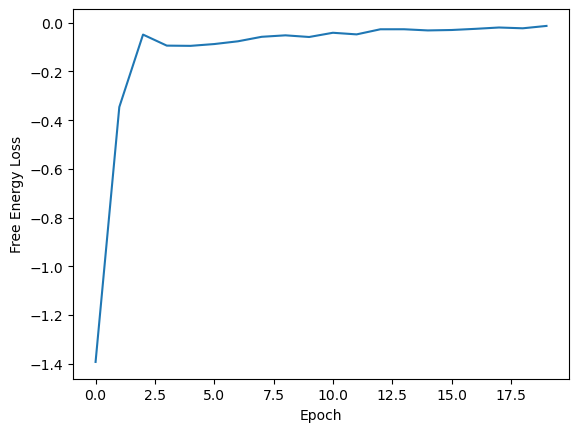

In [16]:
plt.plot([metrics[epoch]['loss_amp'] for epoch in metrics])
plt.xlabel("Epoch")
plt.ylabel("Free Energy Loss")